## Pools Liquidity in GBOOT

In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=True)

network,id,type_id,balances,swap_fee,reserve_coin_denoms
bostrom,1,1,"[{'denom': 'boot', 'amount': '798996561003'}, {...",0.003,"[boot, hydrogen]"
bostrom,2,1,"[{'denom': 'boot', 'amount': '8371441001'}, {'d...",0.003,"[boot, milliampere]"
bostrom,3,1,"[{'denom': 'boot', 'amount': '721334121511'}, {...",0.003,"[boot, tocyb]"
bostrom,4,1,"[{'denom': 'hydrogen', 'amount': '1835727816430...",0.003,"[hydrogen, tocyb]"
bostrom,5,1,"[{'denom': 'hydrogen', 'amount': '160794119772'...",0.003,"[hydrogen, milliampere]"
bostrom,6,1,"[{'denom': 'hydrogen', 'amount': '208541876471'...",0.003,"[hydrogen, millivolt]"
bostrom,7,1,"[{'denom': 'hydrogen', 'amount': '388542504855'...",0.003,"[hydrogen, uosmo in bostrom]"
bostrom,8,1,[],0.003,"[hydrogen, deprecated uatom in bostrom]"
bostrom,9,1,"[{'denom': 'uosmo in bostrom', 'amount': '45097...",0.003,"[uosmo in bostrom, deprecated uatom in bostrom]"
bostrom,10,1,"[{'denom': 'milliampere', 'amount': '25758962'}...",0.003,"[milliampere, millivolt]"


#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True)

,uosmo in bostrom,hydrogen,boot in osmosis,pussy in bostrom,boot,uatom in bostrom,deprecated uatom in bostrom,uatom in osmosis,uosmo,tocyb,milliampere,millivolt
uosmo in bostrom,1,0.004514,NaN,NaN,NaN,NaN,8.061486,NaN,1,NaN,NaN,NaN
hydrogen,220.226721,1,NaN,NaN,3.426788,2073.960187,NaN,NaN,NaN,2.014563,3866.961128,37429.914559
boot in osmosis,NaN,NaN,1,NaN,1,NaN,NaN,644.941292,64.687799,NaN,NaN,NaN
pussy in bostrom,NaN,NaN,NaN,1,678.21667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot,NaN,0.29007,1,0.001466,1,NaN,NaN,NaN,NaN,0.551712,1051.879298,10447.272984
uatom in bostrom,NaN,0.000479,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN
deprecated uatom in bostrom,0.123303,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
uatom in osmosis,NaN,NaN,0.001541,NaN,NaN,1,NaN,1,0.10073,NaN,NaN,NaN
uosmo,1,NaN,0.015366,NaN,NaN,NaN,NaN,9.868069,1,NaN,NaN,NaN
tocyb,NaN,0.493412,NaN,NaN,1.80168,NaN,NaN,NaN,NaN,1,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,uosmo in bostrom,hydrogen,boot in osmosis,pussy in bostrom,boot,uatom in bostrom,deprecated uatom in bostrom,uatom in osmosis,uosmo,tocyb,milliampere,millivolt
uosmo in bostrom,1,0.004514,0.015366,NaN,0.015366,9.868069,8.061486,9.868069,1,NaN,NaN,NaN
hydrogen,220.226721,1,3.426788,NaN,3.426788,2073.960187,NaN,2073.960187,220.226721,2.014563,3866.961128,37429.914559
boot in osmosis,64.687799,0.29007,1,0.001466,1,644.941292,NaN,644.941292,64.687799,0.551712,1051.879298,10447.272984
pussy in bostrom,NaN,NaN,678.21667,1,678.21667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot,64.687799,0.29007,1,0.001466,1,644.941292,NaN,644.941292,64.687799,0.551712,1051.879298,10447.272984
uatom in bostrom,0.10073,0.000479,0.001541,NaN,0.001541,1,NaN,1,0.10073,NaN,NaN,NaN
deprecated uatom in bostrom,0.123303,NaN,NaN,NaN,NaN,NaN,1,NaN,0.123303,NaN,NaN,NaN
uatom in osmosis,0.10073,0.000479,0.001541,NaN,0.001541,1,NaN,1,0.10073,NaN,NaN,NaN
uosmo,1,0.004514,0.015366,NaN,0.015366,9.868069,8.061486,9.868069,1,NaN,NaN,NaN
tocyb,NaN,0.493412,1.80168,NaN,1.80168,NaN,NaN,NaN,NaN,1,NaN,NaN


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GBOOT"
bostrom,1,"[boot, hydrogen]","1,598.0"
bostrom,2,"[boot, milliampere]",16.7
bostrom,3,"[boot, tocyb]","1,442.7"
bostrom,4,"[hydrogen, tocyb]","1,065.0"
bostrom,5,"[hydrogen, milliampere]",93.3
bostrom,6,"[hydrogen, millivolt]",121.0
bostrom,7,"[hydrogen, uosmo in bostrom]",225.4
bostrom,8,"[hydrogen, deprecated uatom in bostrom]",0.0
bostrom,9,"[uosmo in bostrom, deprecated uatom in bostrom]",0.6
bostrom,10,"[milliampere, millivolt]",54.2


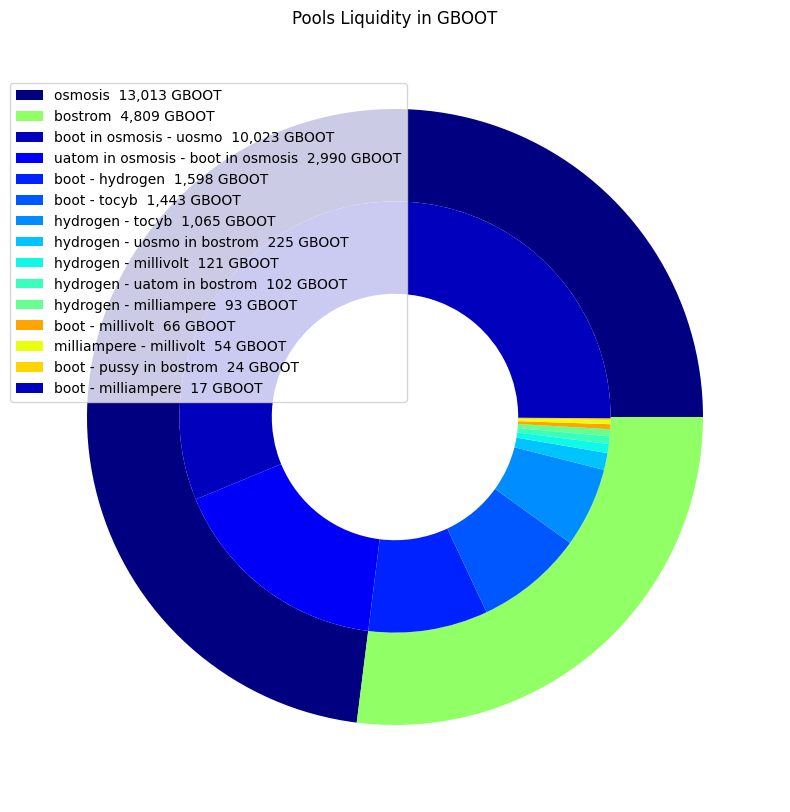

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'boot', main_liquidity_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']:int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return 0

pools_df['liquidity, GBOOT'] = pools_df['balances'].map(get_pool_liquidity)/1e9
display(HTML(pools_df[['network', 'id', 'reserve_coin_denoms', 'liquidity, GBOOT']]
             .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
             .replace('text-align: left;', 'text-align: right')
             .replace('<tr>', '<tr align="right">')))

fig, ax = plt.subplots(figsize=(10,10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.arange(2)*10)

pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df[pools_df.denoms != 'uatom in osmosis - uosmo'].sort_values('liquidity, GBOOT').groupby('network')['liquidity, GBOOT'].sum().sort_values(ascending=False)
inner = pools_df[(pools_df.denoms != 'uatom in osmosis - uosmo') & (pools_df['liquidity, GBOOT'] > 1)].sort_values('liquidity, GBOOT').groupby(['network', 'denoms'])['liquidity, GBOOT'].sum().sort_values(ascending=False)
inner_labels = ['{1}  {2:>,.0f} GBOOT'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GBOOT'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 12, 13]))
ax.pie(inner.values.flatten(), radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set(aspect="equal", title='Pools Liquidity in GBOOT')

plt.legend(outer_labels + inner_labels, loc=(0, 0.52))
handles, labels = ax.get_legend_handles_labels()
plt.show()